# MedAI - Informing and Calming AI assistant for healthcare

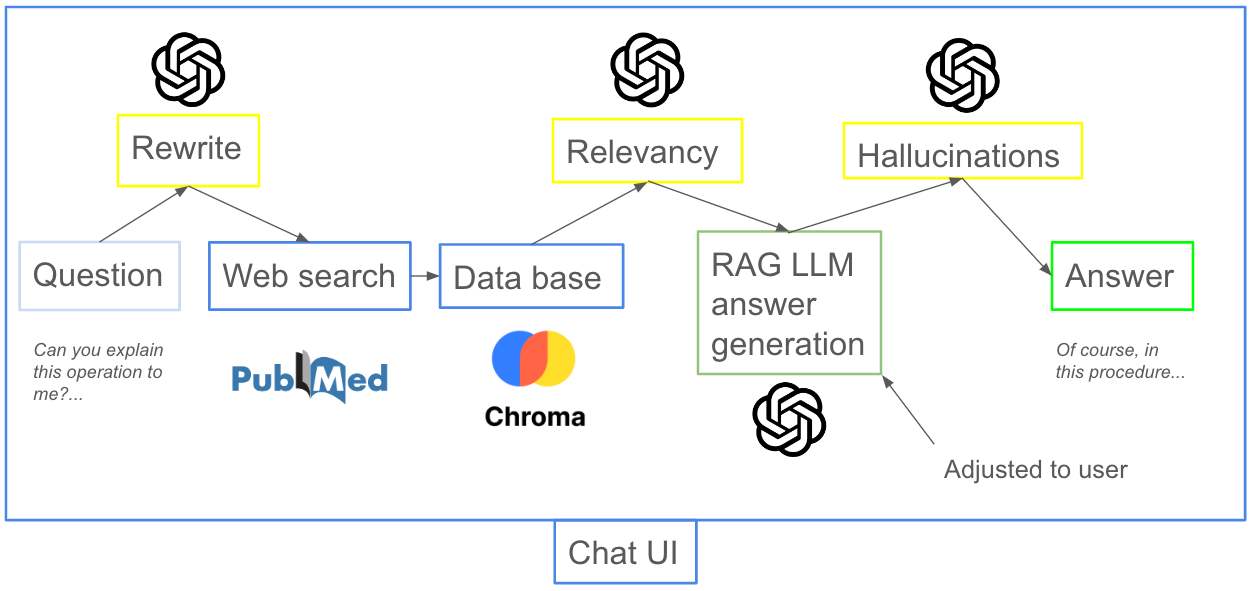





# Dependencies

In [ ]:
!pip install -U langchain-ollama
!pip install colab-xterm
%load_ext colabxterm
!pip install requests beautifulsoup4
!pip install biopython
!pip install chromadb
!pip install langchain_community
!pip install streamlit
!pip install --upgrade pyngrok

In [ ]:
#imports
import langchain
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from Bio import Entrez
import requests
from bs4 import BeautifulSoup
import torch
from transformers import AutoTokenizer, AutoModel
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
import chromadb
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer


# Load and serve model via ollama


In [ ]:
#load Ollama via xterm(or console if not on colab) to host llm locally, use lines below
# curl https://ollama.ai/install.sh | sh
# ollama serve & pull llama3.1
%xterm

In [ ]:
#check if model is correctly loaded and available
!ollama list


# Knowledge retrieval


In [ ]:
#query pubmed and retrieve dois of relevant articles

#fetch dois of relevant articles from pubmed on demand
def fetch_pubmed_articles(query, num_of_articles):
    Entrez.email = "your_email@example.com"
    handle = Entrez.esearch(db="pubmed", term= query, retmax= num_of_articles)
    record = Entrez.read(handle)
    ids = record["IdList"]
    doilist = []
    for id in ids:
      summary = Entrez.esummary(db="pubmed", id=id)
      try:
        doilist.append(Entrez.read(summary)[0]["ArticleIds"]["doi"])
      except:
        continue
    return doilist

#resolve doi and scrape paper text from web
def resolve_doi(doi):
    """
    Resolves a DOI to its URL.
    :param doi: Digital Object Identifier (DOI) of the paper
    :return: URL of the paper
    """
    doi_url = f"https://doi.org/{doi}"
    try:
        response = requests.get(doi_url, allow_redirects=True)
        if response.status_code == 200:
            return response.url
    except requests.RequestException as e:
        None
        #print(f"Error resolving DOI: {e}")
    return None

def scrape_paper_text(url):
    """
    Scrapes text from a paper's URL.
    :param url: URL of the paper
    :return: Extracted text content
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx and 5xx)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Example: Extract text from <p> tags
        paragraphs = soup.find_all('p')
        text = "\n".join(paragraph.get_text() for paragraph in paragraphs)
        return text
    except requests.RequestException as e:
        None
        #print(f"Error fetching the URL: {e}")
    return None

#bring paper texts into format for knowledge base (dictionary mapping urls of papers to text chunks)
def chunk_texts(textlist):
    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1024, #typically well working chunk size, big enough for enough info, small enough to be efficient
    chunk_overlap  = 128, #some overlap to preserve more coherence
    length_function = len,
    is_separator_regex = False,
    )
    chunked_url_dic = {}
    for tup in textlist:
      chunkeddoc = text_splitter.create_documents([tup[1]])
      chunked_list = []
      for text in chunkeddoc:
          chunked_list.append(text.page_content)
      chunked_url_dic[tup[0]] = chunked_list
    return chunked_url_dic

#implement functions
def retrieve_full_texts(query, num_of_articles):
    fetch_number = num_of_articles + 20 #fetch more dois to fill up til 10 eligible articles are found because some do not work
    doilist = fetch_pubmed_articles(query, fetch_number)
    textlist = []
    upper_bound = num_of_articles
    lower_bound = 0
    while (len(textlist) < num_of_articles):
      for doi in doilist[lower_bound:upper_bound]:
        resolved_url = resolve_doi(doi)
        if resolved_url:
          paper_text = scrape_paper_text(resolved_url)
          if paper_text:
              textlist.append((resolved_url,paper_text))
      lower_bound = upper_bound
      upper_bound += 1
    return chunk_texts(textlist)

# Vectorize articles, construct knowledge base

In [ ]:


# Initialize ChromaDB with up-to-date settings
chroma_client = chromadb.Client(Settings(
    persist_directory="./chromadb_data",  # Directory to persist the database
    anonymized_telemetry=False            # Disable telemetry if not needed
))

# Initialize Hugging Face Embedding Model
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

#define function to embed text chunks
def generate_embedding(text):
    """
    Generate an embedding for the input text using a Hugging Face model.
    """
    return embedding_model.encode(text).tolist()

#create database
def create_collection(collection_name):
    """
    Create or get an existing ChromaDB collection.
    """
    return chroma_client.get_or_create_collection(name=collection_name)

#add text chunks to database
def add_documents_to_collection(collection, documents):
    """
    Add documents with their embeddings to a ChromaDB collection.
    """
    for id1, url in enumerate(documents):
      for id2, doc in enumerate(documents[url]):
        embedding = generate_embedding(doc)
        collection.add(
            documents=[doc],  # Text content
            metadatas=[{"source": f"{url}"}],  # Metadata
            ids=[f"id_{id1}:{id2}"],  # Unique ID
            embeddings=[embedding]  # Vector embeddings
        )

#retrieve relevant text chunks from the database for the question
def query_collection(collection, query, top_k=3):
    """
    Query the ChromaDB collection using a text query.
    """
    query_embedding = generate_embedding(query)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k
    )
    return results

#automate retrieval of relevant text chunks from fetched articles based on user question
def return_relevant_chunks(chunked_list_dic, query):
    collection = create_collection("pubmed_knowledge")
    add_documents_to_collection(collection, chunked_list_dic)
    results = query_collection(collection, query)
    relevant_chunks = ""
    for doc, metadata in zip(results["documents"][0], results["metadatas"][0]):
        relevant_chunks += f"{doc} {metadata}\n"
    return relevant_chunks


# Instantiate necessary LLM chains

In [ ]:
#define all necessary llm versions for advanced RAG checkup methods

#query rewriter
template_query_rewrite = """You are an agent that rewrites questions of users into search queries. \n
The query is supposed to yield the best results when used to search for relevant documents to answer the question in an online medical archive. \n
Here is the user question: {question} \n
return your best query to that question and nothing else. \n
Be concise, your answer should not exceed 5 words \n
Answer:
"""
prompt_query_rewrite = ChatPromptTemplate.from_template(template_query_rewrite)
model = OllamaLLM(model="llama3.1")
#construct chain
Query_rewriter = prompt_query_rewrite | model




#Retrieval Grader
llm = ChatOllama(model="llama3.1", format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()


#hallucination grader
# Prompt
prompt_hallucination = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n
    Here are the facts:
    \n ------- \n
    {documents}
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt_hallucination | llm | JsonOutputParser()




#All Assistents
#For young children
llm = ChatOllama(model="llama3.1", temperature=0)

prompt_assistent_young = PromptTemplate(
    template="""You are a medical assistent that helps patients with their medical questions \n
    The User is under 12 years old, so you have to try to answer the question in very simple terms \n
    Try to be empathetic and soothing if appropriate \n
    Here is the user question: {question} \n
    Here is relevant information to answer the question: {document}""",
    input_variables=["question", "document"],
)
Assistent_Young = prompt_assistent_young | llm | StrOutputParser()


#For middle aged people
prompt_assistent_middle = PromptTemplate(
    template="""You are a medical assistent that helps patients with their medical questions \n
    The User is between 12 and 55 years old, so try to be very precise in your answer and as extensive as it needs to be \n
    Try to be empathetic and soothing when appropriate \n
    Here is the user question: {question} \n
    Here is relevant information to answer the question: {document}""",
    input_variables=["question", "document"],
)
Assistent_Middle = prompt_assistent_middle | llm | StrOutputParser()


#For old people
prompt_assistent_old = PromptTemplate(
    template="""You are a medical assistent that helps patients with their medical questions \n
    The User is over 55 years old, so try to be very precise in your answer, but keep the answer relatively short and understandable \n
    Try to be empathetic and soothing when appropriate \n
    Here is the user question: {question} \n
    Here is relevant information to answer the question: {document}""",
    input_variables=["question", "document"],
)
Assistent_Old = prompt_assistent_old | llm | StrOutputParser()

# Run Pipeline

In [ ]:
#RUN ALL

#determine user age for adjusted responses
Age = input("Hello! I am here to assist you with your medical questions, but at first i have to know how old you are. Please enter only your age in years ")
Age = int(Age)
#user input, question
question = input("Great! How can i help you? ")

#rewrite question to suitable query for pubmed search
query = Query_rewriter.invoke({"question": question})

#search pubmed with query
print("I can help with that! I am searching online for relevant documents")
medical_texts = retrieve_full_texts(query, 10)

#vectorize articles and return relevant chunks
relevant_chunks = return_relevant_chunks(medical_texts, question)
print("I found something interesting, let me check if it fits to your question")


#check relevancy of retrieval by llm

relevancy_assessment = retrieval_grader.invoke({"question": question, "document": relevant_chunks})
if relevancy_assessment["score"] == "no":
  print("Oh I am sorry there is no information i could answer your question with...")
elif relevancy_assessment["score"] == "yes":
  print("looks like i found the right information!")

#generate actual prompt
def generate_answer(question, relevant_chunks):
    if Age < 12:
      Answer = Assistent_Young.invoke({"question": question, "document": relevant_chunks})
    elif Age <55:
      Answer = Assistent_Middle.invoke({"question": question, "document": relevant_chunks})
    else:
      Answer = Assistent_Old.invoke({"question": question, "document": relevant_chunks})
    return Answer

Answer = generate_answer(question, relevant_chunks)

#check for hallucinations
#->regenerate if needed
hallucination_assessment = hallucination_grader.invoke({"documents": relevant_chunks, "generation": Answer})
if hallucination_assessment["score"] == "no":
  print("Oh sorry let me concentrate again...")
  for i in range(3):
    if hallucination_assessment["score"] == "no":
      Answer = generate_answer(question, relevant_chunks)
      hallucination_assessment = hallucination_grader.invoke({"documents": relevant_chunks, "generation": Answer})
    else:
      continue

print("oh yes right! Here's the answer to your question: ")

#display final result
print(Answer)

# Write Streamlit app

In [ ]:
%%writefile app.py
import streamlit as st
# Build an app with streamlit

import chromadb

chromadb.api.client.SharedSystemClient.clear_system_cache()
import langchain
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from Bio import Entrez
import requests
from bs4 import BeautifulSoup
import torch
from transformers import AutoTokenizer, AutoModel
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
import chromadb
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
#predefine all codeblocks from above


#query pubmed and retrieve dois of relevant articles

#fetch dois of relevant articles from pubmed on demand
def fetch_pubmed_articles(query, num_of_articles):
    Entrez.email = "your_email@example.com"
    handle = Entrez.esearch(db="pubmed", term= query, retmax= num_of_articles)
    record = Entrez.read(handle)
    ids = record["IdList"]
    doilist = []
    for id in ids:
      summary = Entrez.esummary(db="pubmed", id=id)
      try:
        doilist.append(Entrez.read(summary)[0]["ArticleIds"]["doi"])
      except:
        continue
    return doilist

#resolve doi and scrape paper text from web
def resolve_doi(doi):
    """
    Resolves a DOI to its URL.
    :param doi: Digital Object Identifier (DOI) of the paper
    :return: URL of the paper
    """
    doi_url = f"https://doi.org/{doi}"
    try:
        response = requests.get(doi_url, allow_redirects=True)
        if response.status_code == 200:
            return response.url
    except requests.RequestException as e:
        pass
        #print(f"Error resolving DOI: {e}")
    return None

def scrape_paper_text(url):
    """
    Scrapes text from a paper's URL.
    :param url: URL of the paper
    :return: Extracted text content
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx and 5xx)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Example: Extract text from <p> tags
        paragraphs = soup.find_all('p')
        text = "\n".join(paragraph.get_text() for paragraph in paragraphs)
        return text
    except requests.RequestException as e:
        pass
        #print(f"Error fetching the URL: {e}")
    return None

#bring paper texts into format for knowledge base (dictionary mapping urls of papers to text chunks)
def chunk_texts(textlist):
    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1024, #typically well working chunk size, big enough for enough info, small enough to be efficient
    chunk_overlap  = 128, #some overlap to preserve more coherence
    length_function = len,
    is_separator_regex = False,
    )
    chunked_url_dic = {}
    for tup in textlist:
      chunkeddoc = text_splitter.create_documents([tup[1]])
      chunked_list = []
      for text in chunkeddoc:
          chunked_list.append(text.page_content)
      chunked_url_dic[tup[0]] = chunked_list
    return chunked_url_dic

#implement functions
def retrieve_full_texts(query, num_of_articles):
    fetch_number = num_of_articles + 20 #fetch more dois to fill up til 10 eligible articles are found because some do not work
    doilist = fetch_pubmed_articles(query, fetch_number)
    textlist = []
    upper_bound = num_of_articles
    lower_bound = 0
    while (len(textlist) < num_of_articles):
      for doi in doilist[lower_bound:upper_bound]:
        resolved_url = resolve_doi(doi)
        if resolved_url:
          paper_text = scrape_paper_text(resolved_url)
          if paper_text:
              textlist.append((resolved_url,paper_text))
      lower_bound = upper_bound
      upper_bound += 1
    return chunk_texts(textlist)

# Initialize ChromaDB with up-to-date settings
chroma_client = chromadb.Client(Settings(
    persist_directory="./chromadb_data",
    anonymized_telemetry=False
))

# Initialize Hugging Face Embedding Model
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

#define function to embed text chunks
def generate_embedding(text):
    """
    Generate an embedding for the input text using a Hugging Face model.
    """
    return embedding_model.encode(text).tolist()

#create database
def create_collection(collection_name):
    """
    Create or get an existing ChromaDB collection.
    """
    return chroma_client.get_or_create_collection(name=collection_name)

#add text chunks to database
def add_documents_to_collection(collection, documents):
    """
    Add documents with their embeddings to a ChromaDB collection.
    """
    for id1, url in enumerate(documents):
      for id2, doc in enumerate(documents[url]):
        embedding = generate_embedding(doc)
        collection.add(
            documents=[doc],  # Text content
            metadatas=[{"source": f"{url}"}],  # Metadata
            ids=[f"id_{id1}:{id2}"],  # Unique ID
            embeddings=[embedding]  # Vector embeddings
        )

#retrieve relevant text chunks from the database for the question
def query_collection(collection, query, top_k=3):
    """
    Query the ChromaDB collection using a text query.
    """
    query_embedding = generate_embedding(query)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k
    )
    return results

#automate retrieval of relevant text chunks from fetched articles based on user question
def return_relevant_chunks(chunked_list_dic, query):
    collection = create_collection("pubmed_knowledge")
    add_documents_to_collection(collection, chunked_list_dic)
    results = query_collection(collection, query)
    relevant_chunks = ""
    for doc, metadata in zip(results["documents"][0], results["metadatas"][0]):
        relevant_chunks += f"{doc} {metadata}\n"
    return relevant_chunks


#define all necessary llm versions for advanced RAG checkup methods

#query rewriter
template_query_rewrite = """You are an agent that rewrites questions of users into search queries. \n
The query is supposed to yield the best results when used to search for relevant documents to answer the question in an online medical archive. \n
Here is the user question: {question} \n
return your best query to that question and nothing else. \n
Be concise, your answer should not exceed 5 words \n
Answer:
"""
prompt_query_rewrite = ChatPromptTemplate.from_template(template_query_rewrite)
model = OllamaLLM(model="llama3.1")
#construct chain
Query_rewriter = prompt_query_rewrite | model




#Retrieval Grader
llm = ChatOllama(model="llama3.1", format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()


#hallucination grader
# Prompt
prompt_hallucination = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n
    Here are the facts:
    \n ------- \n
    {documents}
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt_hallucination | llm | JsonOutputParser()




#All Assistents
#For young children
llm = ChatOllama(model="llama3.1", temperature=0)

prompt_assistent_young = PromptTemplate(
    template="""You are a medical assistent that helps patients with their medical questions \n
    The User is under 12 years old, so you have to try to answer the question in very simple terms \n
    Try to be empathetic and soothing if appropriate \n
    Here is the user question: {question} \n
    Here is relevant information to answer the question: {document}""",
    input_variables=["question", "document"],
)
Assistent_Young = prompt_assistent_young | llm | StrOutputParser()


#For middle aged people
prompt_assistent_middle = PromptTemplate(
    template="""You are a medical assistent that helps patients with their medical questions \n
    The User is between 12 and 55 years old, so try to be very precise in your answer and as extensive as it needs to be \n
    Try to be empathetic and soothing when appropriate \n
    Here is the user question: {question} \n
    Here is relevant information to answer the question: {document}""",
    input_variables=["question", "document"],
)
Assistent_Middle = prompt_assistent_middle | llm | StrOutputParser()


#For old people
prompt_assistent_old = PromptTemplate(
    template="""You are a medical assistent that helps patients with their medical questions \n
    The User is over 55 years old, so try to be very precise in your answer, but keep the answer relatively short and understandable \n
    Try to be empathetic and soothing when appropriate \n
    Here is the user question: {question} \n
    Here is relevant information to answer the question: {document}""",
    input_variables=["question", "document"],
)
Assistent_Old = prompt_assistent_old | llm | StrOutputParser()



st.set_page_config(
    page_title="MedAI", page_icon="👨‍⚕️")

st.header("Medical Procedure assistant 👨‍⚕️")


Age = st.radio(
    "Hello! I am here to assist you with your medical questions, but at first i have to know how old you are. Please choose your age range in years: ",
    ("0-11", "12-54", "over 55")
)

# Display the user's selection
if st.button("Submit"):
    st.success(f"You selected: {Age}")
    if Age == "0-11":
      Age = 11
    elif Age == "12-54":
      Age = 54
    elif Age == "over 55":
      Age = 56


# Initialize chat history
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display chat messages from history on app rerun
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

# Accept user input
if prompt := st.chat_input("How can i help you?"):
    # Add user message to chat history
    st.session_state.messages.append({"role": "user", "content": prompt})
    # Display user message in chat message container
    with st.chat_message("user"):
        st.markdown(prompt)

    # Display assistant response in chat message container
    with st.chat_message("assistant"):
        question = prompt
        #rewrite question to suitable query for pubmed search
        query = Query_rewriter.invoke({"question": question})

        #search pubmed with query
        st.write("I can help with that! I am searching online for relevant documents")
        medical_texts = retrieve_full_texts(query, 10)

        #vectorize articles and return relevant chunks
        relevant_chunks = return_relevant_chunks(medical_texts, question)
        st.write("I found something interesting, let me check if it fits to your question")


        #check relevancy of retrieval by llm

        relevancy_assessment = retrieval_grader.invoke({"question": question, "document": relevant_chunks})
        if relevancy_assessment["score"] == "no":
          st.write("Oh I am sorry there is no information i could answer your question with...")
        elif relevancy_assessment["score"] == "yes":
          st.write("looks like i found the right information!")

        #generate actual prompt
        def generate_answer(question, relevant_chunks):
            if Age < 12:
              Answer = Assistent_Young.invoke({"question": question, "document": relevant_chunks})
            elif Age <55:
              Answer = Assistent_Middle.invoke({"question": question, "document": relevant_chunks})
            else:
              Answer = Assistent_Old.invoke({"question": question, "document": relevant_chunks})
            return Answer

        Answer = generate_answer(question, relevant_chunks)

        #check for hallucinations
        #->regenerate if needed
        hallucination_assessment = hallucination_grader.invoke({"documents": relevant_chunks, "generation": Answer})
        if hallucination_assessment["score"] == "no":
          st.write("Oh sorry let me concentrate again...")
          for i in range(3):
            if hallucination_assessment["score"] == "no":
              Answer = generate_answer(question, relevant_chunks)
              hallucination_assessment = hallucination_grader.invoke({"documents": relevant_chunks, "generation": Answer})

        st.write("oh yes right! Here's the answer to your question: ")
        st.write(Answer)

    # Add assistant response to chat history
    st.session_state.messages.append({"role": "assistant", "content": Answer})

# Start Streamlit UI

In [ ]:
!streamlit run /content/app.py &>/content/logs.txt &

In [ ]:
# Set up ngrok to tunnel host for colab
from pyngrok import ngrok

ngrok.set_auth_token("TOKEN") #enter your auth token from ngrok
# Expose the Streamlit port (8501)
public_url = ngrok.connect(addr=8501)
print(f"Public URL: {public_url}")